# Covid-19 Cumulative Confirmed Difference Prediction menggunakan Regresi Linear

Notebook ini digunakan untuk membuat model regresi linear dari dataset menggunakan dua fitur yaitu MRR dan CC.
Perintah pada notebook ini terdiri atas dua bagian, yaitu query data dari database dan melatih model menggunakan data hasil random sampling dari dataset.

---
Pertama, melakukan import terhadap library dan helper yang digunakan. Semua library yang diimport dari `util` dibuat oleh peneliti dan dirancang khusus hanya untuk penelitian ini. Library pada `util` mungkin dapat digunakan pada penelitian lain dengan melakukan beberapa modifikasi.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from util import DbHelper
from util.defaults import db2covid as db_options
import util.modelhelper as modelhelper
import math

# Instantiate DbHelper class for executing
# query to database
db = DbHelper(db_options)

## Bagian 1: Pengambilan data
---
Selanjutnya adalah bagian pertama dari Notebook yang digunakan untuk mendapatkan data dengan melakukan query ke database.

Dua variabel ditetapkan untuk memberikan batasan data yang diambil dari database. Penelitian ini akan menggunakan data terkait covid-19 di Indonesia dari tanggal 1 April hingga 30 September 2020.

In [2]:
min_date = str(db.execute("SELECT MIN(date) FROM COVID19_OPEN_DATA").values.tolist()[0][0])
max_date = str(db.execute("SELECT MAX(date) FROM COVID19_OPEN_DATA").values.tolist()[0][0])

In [3]:
# Options
sr1_code = ''
loc_key = "ID" + ("_" if sr1_code != '' else "") + sr1_code
ndays = 7
lcc_colname = 'DIFF_CC_%dDAYS' % (ndays)

In [4]:
date_index = pd.date_range(start=min_date, end=max_date)

In [5]:
sql = "SELECT DATE, CUMULATIVE_CONFIRMED FROM COVID19_CUMULATIVE_DATA WHERE LOCATION_KEY='%s'" % (loc_key)

cc = db.execute(sql)
cc.index = date_index

In [6]:
diff_lead_cc = db.diff_lead_cum_confirmed_date_range(min_date, max_date, sr1_code, ndays)
diff_lead_cc.index = date_index
diff_lead_cc.columns = [lcc_colname]

In [7]:
cc_dlcc = pd.concat([cc, diff_lead_cc], axis=1)

In [8]:
sql = "SELECT "+ \
      "MOBILITY_RETAIL_AND_RECREATION " + \
      "FROM COVID19_DAILY_MOBILITY_CHANGES "+ \
      "WHERE LOCATION_KEY='%s'" % (loc_key)

In [9]:
mrr = db.execute(sql)
mrr.index = date_index

---
Dibawah ini dapat Anda lihat grafik scatter plot yang memetakan MRR di sumbu x dengan CCD7 di sumbu y. Dari grafik tersebut dapat diketahui bahwa terdapat hubungan positif antara variabel MRR dengan CCD7.

<AxesSubplot:xlabel='MOBILITY_RETAIL_AND_RECREATION', ylabel='DIFF_CC_7DAYS'>

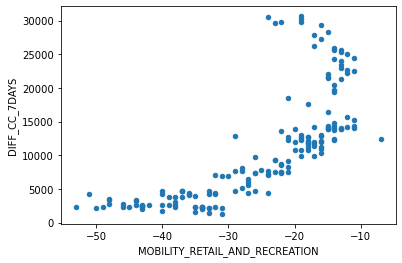

In [10]:
cc_dlcc_mrr = pd.concat([cc_dlcc, mrr], axis=1)

cc_dlcc_mrr.plot.scatter(x='MOBILITY_RETAIL_AND_RECREATION', y=lcc_colname)

## Bagian 2: Melatih model
---
Dibawah ini merupakan bagian kedua untuk melatih model regresi linear menggunakan dataset yang sudah diambil pada bagian 1.

Sebelum melakukan training pada model, dataset akan dibagi menjadi dua bagian. Satu bagian menjadi data latih dan bagian lainnya menjadi data uji. Pada penelitian ini, dalam membagi dataset ke data latih dan data uji digunakan metode random sampling dengan 40% data akan menjadi data latih dan 60% menjadi data uji.

Data uji akan digunakan untuk mengetahui kinerja dari model dalam memprediksi nilai.

Fitur yang digunakan adalah `CUMULATIVE_CONFIRMED` atau CC dan `MOBILITY_RETAIL_AND_RECREATION` atau MRR. Nilai yang diprediksi adalah CCD7.

In [11]:
# covid_X adalah fitur dan covid_y adalah target
covid_X = cc_dlcc_mrr[['CUMULATIVE_CONFIRMED', 'MOBILITY_RETAIL_AND_RECREATION']]
covid_y = cc_dlcc_mrr[lcc_colname]

covid_X = np.array(covid_X.values.tolist())
covid_y = np.array(covid_y.values.tolist())

n_null = ndays * -1

covid_X_unknown = covid_X[n_null:] # Save null y from X dataset

# Bersihkan dari nilai null
covid_X = covid_X[:n_null]
covid_y = covid_y[:n_null]

---
Baris kode dibawah ini digunakan untuk melatih model. Method `get_model_above_threshold` digunakan untuk membantu peneliti dalam melatih model sehingga mendapat nilai r-squared diatas batas minimum tertentu.

Parameter pada perintah tersebut adalah: <br>
`get_model_above_threshold( fitur_train, target_train, r2_threshold, train_ratio)`

Method diatas dibuat oleh peneliti untuk mempermudah dalam melatih model. Pada implementasinya, perintah tersebut menggunakan class `LinearRegression` dari library `sklearn.linear_model`.

Baris kode dibawah akan menghasilkan model yang memiliki nilai r-squared diatas 0.8. Peneliti menggunakan batas tersebut untuk memperoleh model yang dapat memprediksi nilai dengan baik.

In [12]:
model = modelhelper.get_model_above_threshold(covid_X, covid_y, 0.8, 0.4)
#repo = modelhelper.get_model_above_threshold(covid_X, covid_y, repo.r2_score(), 0.4)

In [13]:
model.r2_score()

0.9743726562041346

In [14]:
model.get_model().intercept_

2847.350410973596

In [15]:
model.mean_squared_error()

1355238.316870405

In [16]:
model.r2_score()

0.9743726562041346

In [17]:
model.rmse()

1164.1470340426956

---
Model dapat dilatih terus menerus untuk mendapatkan hasil yang paling optimal dengan nilai r-squared paling tinggi dan nilai RMSE paling rendah.

Pada suatu kondisi, peneliti berhasil memperoleh model yang memiliki r-squared 0.991504 dengan RMSE 717.393.

Setelah mendapatkan model yang dikehendaki, model dapat disimpan menggunakan perintah `dump` dengan nama file tertentu. Peneliti membuat perintah `dump` dengan menyertakan class ModelRepository dari library `util` untuk mempermudah dalam eksekusinya. Apabila model akan digunakan diluar dari lingkungan penelitian ini maka semua file pada library `util` juga harus diikutsertakan.

In [18]:
# Baris ini di-uncomment untuk export model ke folder ./model
# model.dump('model/regr-model-v2_%s-%d_%d.joblib' % (loc_key, ndays, math.ceil(repo.r2_score() * 100)) )